In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

## 1. Who Will Win The Elections?

### 1.1. Load and check

#### 1.1.1. Load data, and do the basic checks

In [2]:
election = pd.read_csv('us-elections_2000-2020.csv.bz2', sep="\t")
print(f"Rows, Columns: {election.shape}\n")
print("Number of NaN values in each column")
print(election.isna().sum())
print("\nSample")
print(election.sample(3))

Rows, Columns: (37390, 24)

Number of NaN values in each column
FIPS                 0
year                 0
state                0
state2               0
county               0
office               0
candidate            0
party                0
candidatevotes       4
totalvotes           0
income            6762
population        6762
LND010200D           0
EDU695209D           0
EDU600209D           0
POP010210D           0
POP220210D           0
POP250210D           0
POP320210D           0
POP400210D           0
PST110209D           0
BIRTHS2020          20
DEATHS2020          20
region               0
dtype: int64

Sample
        FIPS  year      state state2        county     office     candidate  \
25166  39163  2000       Ohio     OH        Vinton  President       Al Gore   
13287  22043  2020  Louisiana     LA  Grant Parish  President  Joshep Biden   
25237  39173  2020       Ohio     OH   Wood County  President  Joshep Biden   

          party  candidatevotes  totalvotes  .

Data looks fine, just a few columns with missing values, specifically income and population, both with 6762 missing values.

### 1.2 Fill missings

#### 1.2.1. print the rows of the data frame from index 6264 to 6271 (i.e. these index values of the data frame). For simplicity, you may only include variables fips, county, year and income.

In [3]:
ele_short = election[["FIPS", "county", "year", "income"]].copy()
rg = np.arange(6264,6272)
print(ele_short.loc[rg])

       FIPS        county  year   income
6264  15007         Kauai  2016  44958.0
6265  15007         Kauai  2016  44958.0
6266  15007  Kauai County  2020      NaN
6267  15007  Kauai County  2020      NaN
6268  15009          Maui  2000      NaN
6269  15009          Maui  2000      NaN
6270  15009          Maui  2004      NaN
6271  15009          Maui  2004      NaN


#### 1.2.2.a. Which values do you expect to see instead of NA-s in lines 6266, 6267, 6268 and 6269?

I would expect to see the incomes of those counties at those years, but since those values are missing, I would expect to see the most recent values for the FIPS code.

#### 1.2.2.b. How is it related to the non-missing income, county and fips values?

Depending on whether or not the income rose or rise during those years, rows with the same FIPS values should have relatively similar/close income values.

#### 1.2.2.c. What method would you use to fill in the missings (what computer code and variables)?

I would first sort the values by year(sort_values("year")), then group using the FIPS code (groupby("FIPS")), then forward fill the na values(fillna(method = "ffill"))

#### 1.2.3. Fill the missings in all columns you need (not only in income) with the most recent values that exist in the data. Ensure you do not fill missings with values from other counties.

In [4]:
election["FIPS2"] = election["FIPS"]
election_filled = election.sort_values("year").groupby("FIPS2").fillna(method="ffill")
print("Number of NaN values in each column")
print(election_filled.isna().sum())

Number of NaN values in each column
FIPS                0
year                0
state               0
state2              0
county              0
office              0
candidate           0
party               0
candidatevotes      2
totalvotes          0
income            644
population        644
LND010200D          0
EDU695209D          0
EDU600209D          0
POP010210D          0
POP220210D          0
POP250210D          0
POP320210D          0
POP400210D          0
PST110209D          0
BIRTHS2020         20
DEATHS2020         20
region              0
dtype: int64


#### 1.2.4.Print out the same lines you did above in 1.1. Does it look what you expected? Pay close attention to the relationship between the FIPS code and the counties.

In [5]:
ele_short = election_filled[["FIPS", "county", "year", "income"]].copy()
rg = np.arange(6264,6272)
print(ele_short.loc[rg])

       FIPS        county  year   income
6264  15007         Kauai  2016  44958.0
6265  15007         Kauai  2016  44958.0
6266  15007  Kauai County  2020  44958.0
6267  15007  Kauai County  2020  44958.0
6268  15009          Maui  2000      NaN
6269  15009          Maui  2000      NaN
6270  15009          Maui  2004      NaN
6271  15009          Maui  2004      NaN


Kauai with FIPS code of 15007 was what I expected, they used the most recent year from 2020 (year 2016) to fill the NaN values. What I didn't expect was Maui to not be filled, but after filtering the income for Maui, I realized that all rows of Maui are NaN values.

### 1.3. Feature Engineering

#### 1.3.1. Make a new data frame that only contains 2020 data, and that contains a binary variable: whether or not democrats won in that county in 2020.

In [6]:
election_2020 = election_filled[election_filled.year == 2020].sort_values("FIPS").reset_index()
elec_2020_d = election_2020[election_2020.party == "democrat"].sort_values("FIPS").reset_index()
elec_2020_r = election_2020[election_2020.party == "republican"].sort_values("FIPS").reset_index()
FIPS = np.sort(pd.unique(election_2020.FIPS))
demo_win = np.where(elec_2020_d.candidatevotes > elec_2020_r.candidatevotes, 1, 0)
fips_win = pd.DataFrame({"FIPS": FIPS, "d_win": demo_win})
election_2020 = election_2020.merge(fips_win, left_on="FIPS", right_on="FIPS").copy().reset_index()
print(fips_win)
print(election_2020[["FIPS", "county", "party", "candidatevotes", "totalvotes", "d_win"]])

       FIPS  d_win
0      1001      0
1      1003      0
2      1005      0
3      1007      0
4      1009      0
...     ...    ...
3106  56037      0
3107  56039      1
3108  56041      0
3109  56043      0
3110  56045      0

[3111 rows x 2 columns]
       FIPS           county       party  candidatevotes  totalvotes  d_win
0      1001   Autauga County  republican         19838.0       27770      0
1      1001   Autauga County    democrat          7503.0       27770      0
2      1003   Baldwin County    democrat         24578.0      109679      0
3      1003   Baldwin County  republican         83544.0      109679      0
4      1005   Barbour County    democrat          4816.0       10518      0
...     ...              ...         ...             ...         ...    ...
6217  56041     Uinta County  republican          7496.0        9402      0
6218  56043  Washakie County  republican          3245.0        4012      0
6219  56043  Washakie County    democrat           651.0       

#### 1.3.2. Create auxiliary variables: population density (population divided by land area); and percentage of college graduates.

In [7]:
election_2020["popden"] = (election_2020.population/1000)/election_2020.LND010200D
election_2020["pergrad"] = election_2020.EDU695209D/election_2020.population * 100

#### 1.3.3. Are countries with younger population more or less democratic? Compute (estimate) yearly birth rate and death rate. This is normally done as as the number of births/deaths per 1000 people per year, please do the same!

In [8]:
election_2020["birthRate"] = election_2020.BIRTHS2020/1000 * 4
election_2020["deathRate"] = election_2020.DEATHS2020/1000 * 4
election_2020["per_older"] = election_2020.EDU600209D/election_2020.population
print("Number of NaN values in each column")
print(election_2020.isna().sum())
top10 = election_2020.nsmallest(10, 'per_older')

Number of NaN values in each column
level_0             0
index               0
FIPS                0
year                0
state               0
state2              0
county              0
office              0
candidate           0
party               0
candidatevotes      0
totalvotes          0
income            104
population        104
LND010200D          0
EDU695209D          0
EDU600209D          0
POP010210D          0
POP220210D          0
POP250210D          0
POP320210D          0
POP400210D          0
PST110209D          0
BIRTHS2020          0
DEATHS2020          0
region              0
d_win               0
popden            104
pergrad           104
birthRate           0
deathRate           0
per_older         104
dtype: int64


Of the top 10 smallest percentages of persons 25 and over, there are only 2 counties where the Democrats won, hence counties with younger population are less democratic

#### 1.3.4. Ensure that the variables you are going to use are in a reasonable range!

In [9]:
election_2020 = election_2020.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
print(election_2020[["birthRate", "deathRate", "popden", "pergrad", "income"]].min())
print(election_2020[["birthRate", "deathRate", "popden", "pergrad", "income"]].max())

birthRate        0.000000
deathRate        0.000000
popden           0.000173
pergrad          0.000000
income       18183.000000
dtype: float64
birthRate        96.708000
deathRate        83.128000
popden           48.428872
pergrad          26.305673
income       205843.000000
dtype: float64


### 1.4. Model

#### 1.4.1. Estimate logistic regression model where you explain democrats’ winning with population density, education level, income, birth rate, death rate, and census region.

In [10]:
election_2020["incomeper1000"] = election_2020.income/1000
m = smf.ols("d_win ~ region + birthRate + deathRate + popden + pergrad + incomeper1000", data = election_2020).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  d_win   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     337.0
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        09:33:28   Log-Likelihood:                -1524.9
No. Observations:                6116   AIC:                             3068.
Df Residuals:                    6107   BIC:                             3128.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1058      0.018     -5.885      0.000      -0.141      -0.071
region[T.northeast]     0.1372      0.018      7.750      0.000       0.103       0.172
region[T.south]         0.0572      0.009      6.122      0.000       0.039       0.076
region[T.west]          0.1161      0.013      8.982      0.000       0.091       0.141
birthRate               0.0288      0.004      6.471      0.000       0.020       0.038
deathRate              -0.0054      0.005     -1.001      0.317      -0.016       0.005
popden                  0.0054      0.004      1.505      0.132      -0.002       0.012
pergrad                 0.0708      0.002     29.057      0.000       0.066       0.076
incomeper1000          -0.0022      0.000     -4.880      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     1690.122   Durbin-Watson:                   0.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4064.690
Skew:                           1.539   Prob(JB):                         0.00
Kurtosis:                       5.544   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 1.4.2. Why do we use logistic regression here, instead of linear regression?

We use logistic regression here because our dependent variable is binary and not continuous, which is what linear regression is used for.

#### 1.4.3. Interpret the results. Which results are statistically significant?

The intercept means that when birthRate, deathRate, population density (1000/sq mi), percent graduates, and income(1000 USD/capita) is equal to 0 then it is the starting point of counties in the midwest region, also known as the reference category. The coefficients for each region category is then the baseline for counties in those specific regions. The birthRate coef means that for every 1 births/1000 per year the county has, it becomes 0.0288 more to democratic win. While the deathRate means that for every 1 death/1000 per year, the county becomes 0.0054 less to democratic win. The popden coef means that for every 1 increase in population density (1000/sq mi) the county becomes 0.0054 more to democratic win. The pergrad coefficient means that for a 1 percent increase in the county's percent of college graduates, the county is 0.0708 more to democratic win. The incomper1000 coef means that for every 1 increase to income(1000 usd/capita) the county beomes 0.0022 less to democratic win. Of all the coefs all but deathRate and population density is statistcally significant since deathRate and popden's p value are both greater than 0.05.

## 2. Model AirBnB Price

### 2.1. Load and Clean

#### 2.1.1. Load data. I recommend to select only the variables you need below, bedrooms, price, and accommodates. You may return here again and change the variable selection as you need. Even better, check out the usecols argument for read_csv

In [11]:
airbnb = pd.read_csv('airbnb-bangkok-listings.csv.bz2')
airbnb = airbnb[["bedrooms", "price", "accommodates", "room_type"]].copy()
print(airbnb)

       bedrooms      price  accommodates        room_type
0           1.0  $1,845.00             3  Entire home/apt
1           1.0  $1,275.00             2     Private room
2           1.0    $800.00             2     Private room
3           1.0    $800.00             2     Private room
4           1.0  $1,845.00             2     Private room
...         ...        ...           ...              ...
17035       1.0    $664.00             4  Entire home/apt
17036       1.0    $960.00             2  Entire home/apt
17037       2.0  $3,500.00             5  Entire home/apt
17038       1.0  $1,360.00             2  Entire home/apt
17039       1.0  $1,280.00             3  Entire home/apt

[17040 rows x 4 columns]


#### 2.1.2. Do the basic data cleaning:

#### 2.1.2.a. convert price to numeric.

In [12]:
def convert_price(price):
    num = price[1:].replace(',', '')
    return float(num)

airbnb["price"] = airbnb["price"].apply(convert_price)
print(airbnb)

       bedrooms   price  accommodates        room_type
0           1.0  1845.0             3  Entire home/apt
1           1.0  1275.0             2     Private room
2           1.0   800.0             2     Private room
3           1.0   800.0             2     Private room
4           1.0  1845.0             2     Private room
...         ...     ...           ...              ...
17035       1.0   664.0             4  Entire home/apt
17036       1.0   960.0             2  Entire home/apt
17037       2.0  3500.0             5  Entire home/apt
17038       1.0  1360.0             2  Entire home/apt
17039       1.0  1280.0             3  Entire home/apt

[17040 rows x 4 columns]


#### 2.1.2.b. remove entries with missing or invalid price, bedrooms, and other variables you need below

In [13]:
airbnb = airbnb.dropna()

#### 2.1.3. Analyze the distribution of price. Does it look like normal? Does it look like something else? Does it suggest you should do a log-transformation?

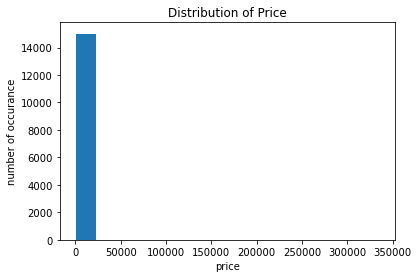

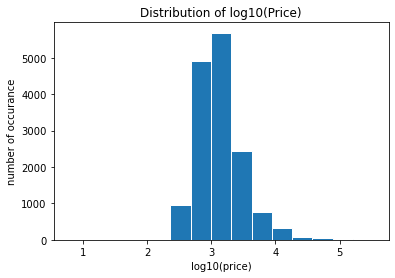

In [14]:
plt.hist(airbnb.price, bins = 15, edgecolor="w")
plt.xlabel("price")
plt.ylabel("number of occurance")
plt.title(label="Distribution of Price")
plt.show()
plt.hist(np.log10(airbnb.price), bins = 15, edgecolor="w")
plt.xlabel("log10(price)")
plt.ylabel("number of occurance")
plt.title(label="Distribution of log10(Price)")
plt.show()

Yes the distribution is extremely skewed so we should do a log transformation

#### 2.1.4. Convert the number of bedrooms into another variable with a limited number of categories only, such as 1, 2, 3, 4+, and use these categories in the models below.

In [15]:
def room_category(room):
    if room == 1:
        return "1"
    elif room == 2:
        return "2"
    elif room == 3:
        return "3"
    else:
        return "4+"
airbnb["roomcat"] = airbnb["bedrooms"]
airbnb["roomcat"] = airbnb["roomcat"].apply(room_category)
airbnb["logprice"] = np.log(airbnb.price)
print(airbnb.roomcat)

0        1
1        1
2        1
3        1
4        1
        ..
17035    1
17036    1
17037    2
17038    1
17039    1
Name: roomcat, Length: 15200, dtype: object


### 2.2. Model

#### 2.2.1. Run a linear regression where you explain the listing price with number of bedrooms where bedrooms uses these categories. Interpret the results, including R2.

In [16]:
m = smf.ols("price ~ roomcat", data = airbnb).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     186.5
Date:                Mon, 22 May 2023   Prob (F-statistic):          9.32e-119
Time:                        09:33:32   Log-Likelihood:            -1.5589e+05
No. Observations:               15200   AIC:                         3.118e+05
Df Residuals:                   15196   BIC:                         3.118e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1742.2689     63.041     27.637      0.000    1618.701    1865.836
roomcat[T.2]   1481.0031    158.427      9.348      0.000    1170.466    1791.540
roomcat[T.3]   3317.3668    292.214     11.353      0.000    2744.591    3890.142
roomcat[T.4+]  6592.1869    329.856     19.985      0.000    5945.629    7238.745
==============================================================================
Omnibus:                    36718.532   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        557010065.623
Skew:                          25.064   Prob(JB):                         0.00
Kurtosis:                     939.470   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The intercept is means the baseline for the reference category 1-BR, which means that 1-BR starts at 1742.2689 in Thai Baht. The T.2 coef means that rooms with 2 bedrooms starts as 1481.0031 Baht, T.3 means 3 bedroom starts as 3317.3668 baht, and T.4+ means that 4 and more bedrooms starts at 6592.1869 Baht. The R Squared value tell us how much of the variance in price is explanined by this model, a R squared of 0.036 means that only 3.6% of the variance in price is explained by the bedroom category, which is small.

#### 2.2.2. Now repeat the process with the model where you analyze log price instead of price. Interpret the results. Which model behaves better in the sense of R2?

In [17]:
m = smf.ols("logprice ~ roomcat", data = airbnb).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     1293.
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        09:33:32   Log-Likelihood:                -16912.
No. Observations:               15200   AIC:                         3.383e+04
Df Residuals:                   15196   BIC:                         3.386e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.0150      0.007   1040.367      0.000       7.002       7.028
roomcat[T.2]      0.6781      0.017     40.014      0.000       0.645       0.711
roomcat[T.3]      1.1249      0.031     35.989      0.000       1.064       1.186
roomcat[T.4+]     1.3712      0.035     38.865      0.000       1.302       1.440
==============================================================================
Omnibus:                     3643.283   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16193.066
Skew:                           1.108   Prob(JB):                         0.00
Kurtosis:                       7.545   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The intercept is means the baseline for the reference category 1-BR, which means that the log price of 1-BR starts at 7.0150 in Thai Baht. The T.2 coef means that the log price of rooms with 2 bedrooms starts as 0.6781 Baht, T.3 means the log price of 3 bedroom starts as 1.1249 baht, and T.4+ means that the log price of 4 and more bedrooms starts at 1.3712 Baht. The R Squared value tell us how much of the variance in price is explanined by this model, a R squared of 0.203 means that only 20.3% of the variance in log price is explained by the bedroom category, which is small, but better than the previous model, which means this model behaves better.

#### 2.2.3. Finally we just add two more variables to the model: room type and accommodates. While room type only contains three values, the other two contain many different categories. Recode these as • accommodates: “1”, “2”, “3”, “4 and more” Run this model. Interpret and comment the more interesting/important results. Do not forget to mention what are the relevant reference categories and R2

In [18]:
def accom_category(accommodation):
    if accommodation == 1:
        return "1"
    elif accommodation == 2:
        return "2"
    elif accommodation == 3:
        return "3"
    else:
        return "4 and more"
airbnb["acomcat"] = airbnb["accommodates"]
airbnb["acomcat"] = airbnb["acomcat"].apply(accom_category)
print(airbnb["acomcat"])

0                 3
1                 2
2                 2
3                 2
4                 2
            ...    
17035    4 and more
17036             2
17037    4 and more
17038             2
17039             3
Name: acomcat, Length: 15200, dtype: object


In [19]:
m = smf.ols("logprice ~ roomcat + acomcat + room_type", data = airbnb).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     539.9
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        09:33:33   Log-Likelihood:                -16531.
No. Observations:               15200   AIC:                         3.308e+04
Df Residuals:                   15190   BIC:                         3.316e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.9007      0.032    215.886      0.000       6.838       6.963
roomcat[T.2]                  0.5087      0.021     24.406      0.000       0.468       0.550
roomcat[T.3]                  0.9379      0.034     27.713      0.000       0.872       1.004
roomcat[T.4+]                 1.2097      0.037     32.816      0.000       1.137       1.282
acomcat[T.2]                  0.1417      0.032      4.466      0.000       0.080       0.204
acomcat[T.3]                  0.2048      0.035      5.904      0.000       0.137       0.273
acomcat[T.4 and more]         0.3136      0.033      9.455      0.000       0.249       0.379
room_type[T.Hotel room]       0.1332      0.028      4.827      0.000       0.079       0.187
room_type[T.Private room]    -0.0583      0.013     -4.528      0.000      -0.084      -0.033
room_type[T.Shared room]     -0.6869      0.033    -20.786      0.000      -0.752      -0.622
==============================================================================
Omnibus:                     4377.153   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22672.783
Skew:                           1.295   Prob(JB):                         0.00
Kurtosis:                       8.394   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The reference category for this model is a 1 bedroom, 1 accommodate, entire home/apt, which will have its log price at 6.9007 baht which isthe intercept. If the room ends up having 2 br, its log price will increase by 0.5087 baht, increase by 0.9379 baht for 3 bedrooms, and 1.2097 baht for 4+ bedrooms. If the room ends up wih 2 accommodates the log price will increase by 0.1417 baht, 0.2048 baht for 3 accommodates, and 0.3136 baht for 4 and more accomodates. If the room ends up being a hotel room, the log price will increase by 0.1332 baht, decrease by 0.0583 baht if its a private room, and decrease by 0.6869 baht if its a shared room. The R squared is 0.242, which means that this model can explain the variance in log prices by 24.2%. Also all coef are statistically significant since their p values are less than 0.05.

### 2.3. Predict

#### 2.3.1. Now use the model above to predict (log) price for each listing in your data.

In [20]:
predictions = m.predict(airbnb)
print(predictions)

0        7.105497
1        6.984033
2        6.984033
3        6.984033
4        6.984033
           ...   
17035    7.214234
17036    7.042362
17037    7.722903
17038    7.042362
17039    7.105497
Length: 15200, dtype: float64


 #### 2.3.2. Compute root-mean-squared-error (RMSE) of this prediction.

In [28]:
squarediff = np.square(airbnb.logprice - predictions)
MSE = np.sum(squarediff)/len(squarediff)
print(f"MSE: {MSE}")
print(f"RMSE: {np.sqrt(MSE)}")

MSE: 0.5154473379771107
RMSE: 0.7179466122053302


#### 2.3.3. Now use your model to predict the price for a 2-bedroom apartment that accommodates 4. You can either leave out the variables that are not specified from your model, or choose reasonable values for those, and explain your reasoning.

I expect the the Airbnb to be an entire home/apt because you can't have 2 rooms with shared and with private room. A hotel room is unlikely to split into two rooms for 4 travellers  
predict = intercept + 2bedroom + 4accomodate

In [32]:
predict = 6.9007 + 0.5087 + 0.3136
print(f"Prediction: {predict} baht")

Prediction: 7.723 baht


#### 2.3.4. Compute the average log price for all listings in this group (2BR apartment that accommodates 4). Compare the result with your prediction. How close did you get?

In [40]:
avg = np.mean(airbnb[(airbnb.bedrooms == 2) & (airbnb.accommodates == 4)].logprice)
print(f"Average price: {avg}")
print(f"Difference = {avg - predict}")

Average price: 7.728450922007445
Difference = 0.005450922007445236


My prediction was close just a difference of 0.00545 baht.

Spent around 3 hrs.